# Classification of Fashion-MNIST using a CNN with Keras

The Fashion-MNIST has 60,000 training samples and 10,000 test samples. Each sample is a 28x28 pixel grayscale (8-bit) image.

Classes:

|Label|Description|
|-----|-----------|
|0|T-shirt/top    |
|1|Trouser        |
|2|Pullover       |
|3|Dress          |
|4|Coat           |
|5|Sandal         |
|6|Shirt          |
|7|Sneaker        |
|8|Bag            |
|9|Ankle boot     |

## Imports

In [47]:
import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D

import numpy as np
import io
import PIL
import IPython
import collections
import hashlib
import matplotlib.pyplot as plt

## Load the data
Luckily, the Fashion-MNIST dataset is included in Keras, so this is a one-liner.

In [64]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

## Transform data / split

In [65]:
num_classes = 10

print(x_train.shape)
print(y_train.shape)
# Add one dimension because the CNN layers expect n feature maps (color channels)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
y_train = keras.utils.to_categorical(y_train, num_classes=num_classes, dtype='float32')
print(x_train.shape)
print(y_train.shape)


# TODO SPLIT

(60000, 28, 28)
(60000,)
(60000, 28, 28, 1)
(60000, 10)


## Data integrity

Check that the data looks reasonable by looking at a few random samples from the dataset.

In [59]:
def render_random_images(num_samples):
    idxs = np.random.choice(len(x_train), num_samples)
    for idx in idxs:
        f = io.BytesIO()
        PIL.Image.fromarray(x_train[idx]).save(f, 'png')
        IPython.display.display(IPython.display.Image(data=f.getvalue()))
    
render_random_images(10)

TypeError: Cannot handle this data type

### Check for duplicates/overlaps

Does the training data and test data contain duplicates or do they overlap?

In [60]:
def overlap(a, b):
    ah = [hashlib.sha1(x).hexdigest() for x in a]
    bh = [hashlib.sha1(y).hexdigest() for y in b]
    overlaps = np.in1d(ah, bh)
    return collections.Counter(overlaps)[True]

def has_duplicates(a):
    ah = [hashlib.sha1(x).hexdigest() for x in a]
    _, counts = np.unique(ah, return_counts=True)    
    if len(collections.Counter(counts).keys()) > 1:
        return True
    return False
  
print("Overlaps between training and test sets:", overlap(x_train, x_test))
print("Duplicates in training set:", has_duplicates(x_train))
print("Duplicates in test set:", has_duplicates(x_test))

Overlaps between training and test sets: 0
Duplicates in training set: False
Duplicates in test set: False


### Check for class imbalance

ValueError: x must have 2 or fewer dimensions

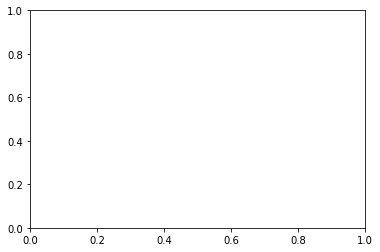

In [61]:
_ = plt.hist(y_train, bins=range(0,11))
_ = plt.hist(y_test, bins=range(0,11))

The classes are equally common. This was expected, but still good to check.

## Model training

### Model definition

In [66]:
print(x_train.shape, y_train.shape)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), input_shape=(28,28,1)))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

sgd = keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

(60000, 28, 28, 1) (60000, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_3 (Flatten)          (None, 21632)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 10)                216330    
Total params: 216,650
Trainable params: 216,650
Non-trainable params: 0
_________________________________________________________________


### Training

In [67]:
epochs = 10
batch_size = 32
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/10
60000/60000 [==============================] - 11s 178us/step - loss: 14.5061 - acc: 0.1000
Epoch 2/10
60000/60000 [==============================] - 10s 171us/step - loss: 14.5063 - acc: 0.1000
Epoch 3/10
60000/60000 [==============================] - 11s 175us/step - loss: 14.5063 - acc: 0.1000
Epoch 4/10
60000/60000 [==============================] - 12s 202us/step - loss: 14.5063 - acc: 0.1000
Epoch 5/10
60000/60000 [==============================] - 12s 205us/step - loss: 14.5063 - acc: 0.1000
Epoch 6/10
60000/60000 [==============================] - 13s 225us/step - loss: 14.5063 - acc: 0.1000
Epoch 7/10
60000/60000 [==============================] - 12s 204us/step - loss: 14.5063 - acc: 0.1000
Epoch 8/10
60000/60000 [==============================] - 12s 199us/step - loss: 14.5063 - acc: 0.1000
Epoch 9/10
52704/60000 [=========================>....] - ETA: 1s - loss: 14.4908 - acc: 0.1010

KeyboardInterrupt: 